In [36]:
import os
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
if not os.path.isfile("owid-covid.csv"):
    with open("owid-covid.csv", "w") as f:
        r = requests.get("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
        f.write(r.text)

In [3]:
df = pd.read_csv("owid-covid.csv")

In [4]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [5]:
COUNTRY = "Germany"

In [6]:
df = df.loc[df["location"] == COUNTRY, :]
df = df.iloc[:-20]

In [7]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

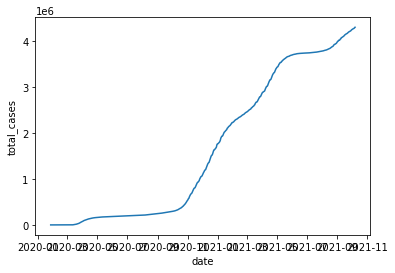

In [8]:
sns.lineplot(x=df["date"], y=df["total_cases"]);

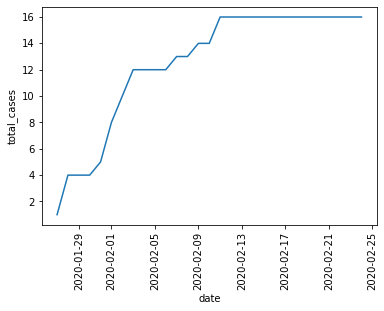

In [9]:
start_date = datetime(2020, 2, 25)
sns.lineplot(x="date", y="total_cases", data=df.loc[df["date"] < start_date]);
plt.xticks(rotation=90);

In [10]:
df = df.loc[df["date"] > start_date]

In [11]:
df["day_number"] = np.arange(1, df.shape[0] + 1)

In [12]:
train_size = int(df.shape[0] * 0.8)
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

In [13]:
train_df.shape, test_df.shape

((472, 66), (118, 66))

/home/imd/miniconda3/envs/mlisuct/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/imd/miniconda3/envs/mlisuct/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


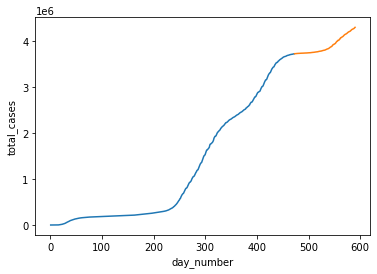

In [14]:
sns.lineplot(train_df["day_number"], train_df["total_cases"]);
sns.lineplot(test_df["day_number"], test_df["total_cases"]);

In [15]:
model = LinearRegression()

In [16]:
features = ["day_number"]
target = "total_cases"

In [17]:
model.fit(train_df[features], train_df[target])

LinearRegression()

In [18]:
prediction = model.predict(test_df[features])

In [19]:
test_df["prediction"] = prediction

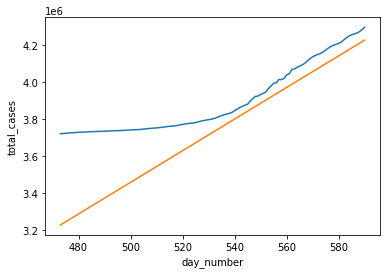

In [20]:
sns.lineplot(x="day_number", y="total_cases", data=test_df);
sns.lineplot(x="day_number", y="prediction", data=test_df);

In [21]:
mean_squared_error(test_df["total_cases"], test_df["prediction"])

47348658086.54471

In [22]:
mean_absolute_error(test_df["total_cases"], test_df["prediction"])

168367.57167299642

In [23]:
model.fit(train_df[features], np.log(train_df[target]))

LinearRegression()

In [24]:
prediction = np.exp(model.predict(test_df[features]))

In [25]:
test_df["prediction"] = prediction

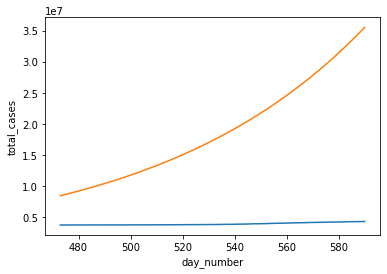

In [26]:
sns.lineplot(x="day_number", y="total_cases", data=test_df);
sns.lineplot(x="day_number", y="prediction", data=test_df);

In [27]:
mean_squared_error(test_df["total_cases"], test_df["prediction"])

281576454429889.9

In [28]:
mean_absolute_error(test_df["total_cases"], test_df["prediction"])

14966751.83261129

In [29]:
train_df["day_number_squared"] = train_df["day_number"] ** 2
test_df["day_number_squared"] = test_df["day_number"] ** 2

In [30]:
features = ["day_number", "day_number_squared"]
target = "new_cases"

In [37]:
model = Ridge()

In [38]:
model.fit(train_df[features], np.log(train_df[target].clip(lower=1)))

Ridge()

In [39]:
prediction = model.predict(test_df[features])

In [40]:
prediction = np.exp(prediction).cumsum() + train_df["total_cases"].iloc[-1]

In [41]:
test_df["prediction"] = prediction

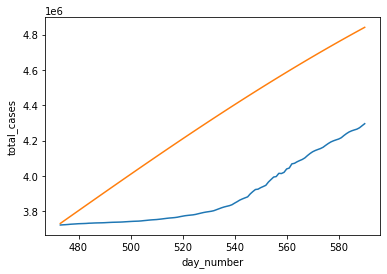

In [42]:
sns.lineplot(x="day_number", y="total_cases", data=test_df);
sns.lineplot(x="day_number", y="prediction", data=test_df);